____

# <font color=#FFAA11> Two-Temperature Model </font>

The TTM considered here is given by
$$\begin{align}
c_e \frac{\partial T_e}{\partial t} &= \frac{1}{r}\frac{\partial}{\partial r}\left(r k_e \frac{\partial T_e}{\partial r}\right) - G (T_e - T_i), \\
c_i\frac{\partial T_i}{\partial t} &= \frac{1}{r}\frac{\partial}{\partial r}\left(r k_i \frac{\partial T_i}{\partial r}\right) + G (T_e - T_i),
\end{align}
$$
which assumes a cylindrical plasma composed of electrons and ions with no mass flow. 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
from physics import JT_GMS, SMT
from constants import *
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from exp_setup import Cylindrical_Grid, Experiment
from TTM_solver import TwoTemperatureModel

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# Create Experimental Information

In [11]:
grid  = Cylindrical_Grid(100e-6, N=200) 
Zstar, A = 2, 4
Te_initial, Ti_initial = 14.79e3, 8.83e3 #[K]
laser_width = 25e-6 # [m]
n0 = 1.83e21 *1e6

dih_file = "/home/zach/plasma/TTM/data/He5bar_DIH_profile_data.txt"


# Create Experimental layout and TTM solver
Helium_jt = Experiment(grid, n0, Zstar, A, Te_initial, Ti_initial,laser_width, gas_name='Helium', model = "JT",
                     ion_temperature_model = 'gaussian', ion_temperature_file = dih_file)
ttm_jt = TwoTemperatureModel(Helium_jt, model = "JT")

Helium_smt = Experiment(grid, n0, Zstar, A, Te_initial, Ti_initial,laser_width, gas_name='Helium', model = "SMT",
                      ion_temperature_model = 'gaussian', ion_temperature_file = dih_file)
ttm_smt = TwoTemperatureModel(Helium_smt, model = "SMT")

Initial peak T_electron converged:  [19372.80568223] True The solution converged.
Te_max = 1.937e+04 K
Using gaussian model for Ti: Ti_max = 1.157e+04 K
Initial peak T_electron converged:  [19372.80568223] True The solution converged.
Te_max = 1.937e+04 K
Using gaussian model for Ti: Ti_max = 1.157e+04 K


In [12]:
print("JT Model")
ttm_jt.make_times()
ttm_jt.print_timescales()

print("\nSMT Model")
ttm_smt.make_times()
ttm_smt.print_timescales()

JT Model

Simulation time: 3.6e-01 ns,  dt = 7.1e+00 ps, steps = 50
  Diffusion time (r_max): e:5.6e+03 ns, i:3.8e+45 ns 
  Diffusion time (dr): e:1.4e-01 ns, i:9.6e+40 ns 
  Thermalization Times: 7.15e+01 ps  7.15e+01 ps

SMT Model

Simulation time: 1.1e-01 ns,  dt = 2.2e+00 ps, steps = 50
  Diffusion time (r_max): e:2.7e+03 ns, i:3.8e+45 ns 
  Diffusion time (dr): e:6.8e-02 ns, i:9.6e+40 ns 
  Thermalization Times: 2.22e+01 ps  2.22e+01 ps


# Solve Two Temperature Model

In [13]:
ttm_jt.solve_TTM(tmax=0.83e-9)
ttm_smt.solve_TTM(tmax=0.83e-9)

/home/zach/plasma/TTM/physics.py:214: RuntimeWarning: invalid value encountered in power
  A = a1*T0_in_eV**a2 + a3*T0_in_eV**a4
/home/zach/plasma/TTM/physics.py:60: RuntimeWarning: invalid value encountered in sqrt
  vth_e = np.sqrt(3*k_B*Te/m_e)
/home/zach/plasma/TTM/physics.py:423: RuntimeWarning: invalid value encountered in power
  τee_dimensional = unit_conversion * (k_B*Te)**(3/2)*np.sqrt(m_e) / (n_e* ee**4 ) # Only certain part of τee, based on dimensional analysis
/home/zach/plasma/TTM/physics.py:83: RuntimeWarning: invalid value encountered in sqrt
  λDe = np.sqrt(ε_0*k_B*Te/(ee**2*n_e) )
/home/zach/plasma/TTM/physics.py:170: RuntimeWarning: invalid value encountered in sqrt
  λ = np.sqrt(3) * hbar / 2 /np.sqrt( 3*k_B*Te/m_e + 0.6*v_F**2)/m_e
/home/zach/plasma/TTM/physics.py:146: RuntimeWarning: invalid value encountered in sqrt
  λdB = hbar /2 /np.sqrt( k_B*Te*m_e ) # from GMS
/home/zach/plasma/TTM/physics.py:904: RuntimeWarning: invalid value encountered in power
  num = 75

# PLOTS

In [14]:
def plot_temp_profiles(ttm, plot_times = None, ax = None, title=''):

    if plot_times is None:
        plot_times = (np.linspace(0,len(ttm.t_list)*0.99,num=4,endpoint=True)).astype(int)  # Intermediate times for plotting        
        
    # Plot temperature profiles at intermediate times
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(14,10),facecolor='w')
    
    plot_idx = 0
    for plot_idx, ti in enumerate(plot_times):
        t = ttm.t_list[ti]
        ax.plot(grid.cell_centers*1e6, ttm.Te_list[ti][:-1]*1e-3, '--', color=colors[plot_idx], label=f"$T_e$: t={t*1e9:.1e} [ns]")
        ax.plot(grid.cell_centers*1e6, ttm.Ti_list[ti][:-1]*1e-3, '-' , color=colors[plot_idx], label=f"$T_i$: t={t*1e9:.1e} [ns]")
        # plot_idx += 1


    # Plot settings
    ax.set_xlabel(r"Radial distance [$\mu$m]",fontsize=20)
    ax.set_ylabel("Temperature [kK]",fontsize=20)
    ax.tick_params(labelsize=20)
    ax.set_xlim(0,50)
    # ax.set_ylim(0,10.1)
    ax.legend(fontsize=15)
    ax.grid(alpha = 0.3)
    ax.set_title(title, fontsize=20)


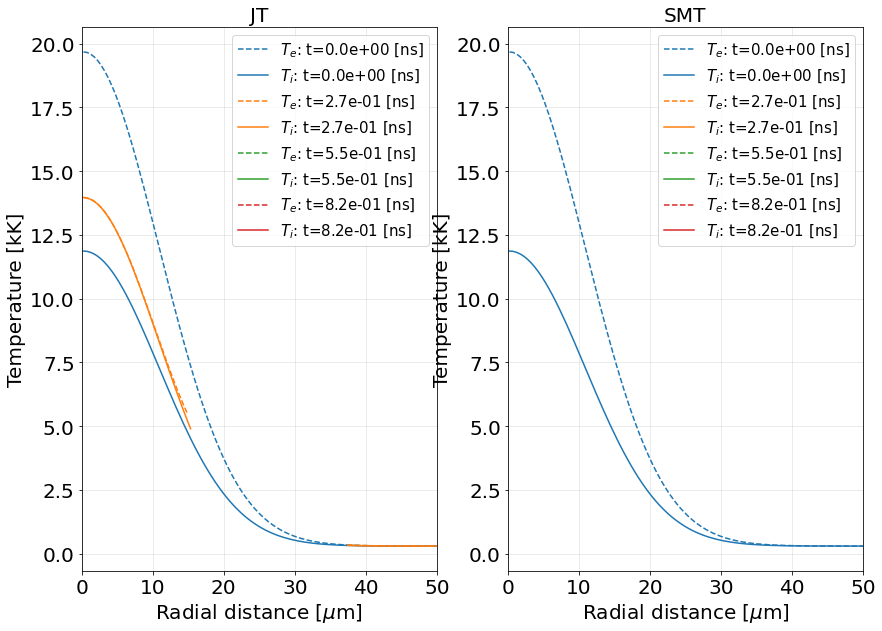

In [15]:
fig, ax = plt.subplots(1,2, figsize=(14,10),facecolor='w')

plot_temp_profiles(ttm_jt, ax = ax[0], title='JT')
plot_temp_profiles(ttm_smt,  ax = ax[1], title='SMT')


In [16]:
He_data = read_csv("./data/experimental_data/He_74bar_Te.txt", delim_whitespace=True, header=1)
He_data

,t[ns],T[kK]
0,0.003175,14.790528
1,0.007937,14.571949
2,0.010317,14.298725
3,0.020635,14.089253
4,0.020635,13.897996
...,...,...
59,0.792063,10.582878
60,0.817460,10.783242
61,0.847619,10.428051
62,0.864286,10.719490


In [17]:
from scipy.optimize import curve_fit

def T_fit_form(t, Te_0, Ti_0, d, τei):
    ΔT0 = (Te_0-Ti_0)
    ΣT0 = (Te_0+Ti_0)
    return ΣT0/2 - d*t + ΔT0/2*np.exp(-2*t/τei)

def T_DIHfit_form(t, Te_0, d, τei):
    Ti_0 = Ti_initial
    ΔT0 = (Te_0-Ti_0)
    ΣT0 = (Te_0+Ti_0)
    return ΣT0/2 - d*t + ΔT0/2*np.exp(-2*t/τei)

Te0_fit, Ti0_fit, d_fit, τei_fit = curve_fit(T_fit_form, He_data['t[ns]'], He_data['T[kK]'] , maxfev=int(1e4))[0]
Te0_DIHfit, d_DIHfit, τei_DIHfit = curve_fit(T_DIHfit_form, He_data['t[ns]'], He_data['T[kK]'] , maxfev=int(1e4))[0]
Te0_DIHfit, d_DIHfit, τei_DIHfit

(12.91101238403583, 3.921206001431775, 15503.800441490777)

In [18]:
def plot_bulk_temperature(ttm, exp, plot_times = None, ax = None, title=''):
    bulk_Tes = np.array([exp.get_bulk_T(Te, ttm.n_e) for Te in ttm.Te_list])
    bulk_Tis = np.array([exp.get_bulk_T(Ti, ttm.n_e) for Ti in ttm.Ti_list]) # Use Zstar weighted density? i.e. use ne not ni
    
    T_av = 0.5*(bulk_Tes + bulk_Tis)
    ti_1, ti_2 = -100, -1

    T_av_1 = T_av[ti_1]
    T_av_2 = T_av[ti_2]

    dT_dt  = (T_av_2 - T_av_1)/(ttm.t_list[ti_2] - ttm.t_list[ti_1])

    T_eq_line  = np.array(T_av_1 + dT_dt*(ttm.t_list-ttm.t_list[ti_1]))


    ax.plot(np.array(ttm.t_list)*1e9, bulk_Tes*1e-3,label=r"$T_e$ (bulk)")
    ax.plot(np.array(ttm.t_list)*1e9, bulk_Tis*1e-3,label=r"$T_i$ (bulk)")
    ax.plot(np.array(ttm.t_list)*1e9, T_eq_line*1e-3,'--k',label='Linear Diffusion line')
#     ax.plot(np.array(ttm.t_list)*1e9, T_av*1e-3,'-k',label='Average (initial: T={0:.2f} [kK])'.format(T_av[0]*1e-3))
    
#     bulk_T_exp_fit = (Te_initial + Ti_initial)/2 - 0.5*120*1e9*ttm.t_list + (Te_initial - Ti_initial)/2 * np.exp(-ttm.t_list/(1470e-12))
#     print(bulk_T_exp_fit)
    ax.plot(ttm.t_list*1e9, T_fit_form(ttm.t_list*1e9, Te0_fit, Ti0_fit, d_fit, τei_fit),'r--' ,label="Experiment Fit")
    ax.plot(ttm.t_list*1e9, T_DIHfit_form(ttm.t_list*1e9, Te0_fit, d_fit, τei_fit),'r-.' ,label="Experiment DIH fixed Fit")
    ax.plot(He_data['t[ns]'], He_data['T[kK]'], 'r-', label='Experiment Data')
    # Thermalization Text
    thermalization_text = r'$\tau_{th}$' + ' = {0:.1f} [ps] (exp 63 ps)'.format(ttm.experiment.τei_Equilibration*1e12)
    thermalization_head_x_pos = 0.5* ttm.experiment.τei_Equilibration*1e9
    thermalization_head_y_pos = bulk_Tes[np.argmin(np.abs(ttm.t_list-thermalization_head_x_pos*1e-9))]*1e-3
    
    thermalization_arrow_head_coords = (thermalization_head_x_pos, thermalization_head_y_pos )
    ax.annotate(thermalization_text, xy=thermalization_arrow_head_coords, xycoords='data',
                xytext=(150, 60), textcoords='offset points',
                va='top', ha='left',fontsize=15,
                arrowprops=dict(facecolor='black', shrink=0.02))

    # Diffusion Text
    diffusion_text = 'Diffusion Estimate:\n dT/dt={0:.2f} [K/ns] (exp -1530 K/ns)'.format(dT_dt*1e-9)
    diffusion_head_x_pos = 0.5*ttm.tmax*1e9
    diffusion_head_y_pos = 0.1 + bulk_Tes[np.argmin(np.abs(ttm.t_list-diffusion_head_x_pos*1e-9))]*1e-3
    
    diffusion_arrow_head_coords = (diffusion_head_x_pos, diffusion_head_y_pos )
    ax.annotate(diffusion_text, xy=diffusion_arrow_head_coords, xycoords='data',
                xytext=(60, -30), textcoords='offset points',
                va='top', ha='left',fontsize=15,
                arrowprops=dict(facecolor='black', shrink=0.02))
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)

    # place a text box in upper left in axes coords
    fit_string =  (r"My fit: $τ_{{ei}}$ = {0:.1f} [ps]".format(τei_fit*1e3) + '\n'+
                   r" $dT_e/dt$ = -{0:.1f} K/ns".format(d_fit*1e3) + '\n' +
                   r" $T^{{\rm init}}_e$ = {0:.2f} [kK]".format(Te0_fit) + '\n' +
                   r" $T^{{\rm init}}_i$ = {0:.2f} [kK]".format(Ti0_fit)

                  )
    ax.text(0.5, 0.95, fit_string, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)



    # Plot settings
    ax.set_xlabel(r"Time [ns]", fontsize=20)
    ax.set_ylabel("Temperature [kK]",fontsize=20)
    ax.tick_params(labelsize=20)
    ax.set_xlim(-0.01,ttm.tmax*1e9)
    ax.set_ylim(9,15)

    ax.set_title(title,fontsize=20)
    ax.legend(fontsize=14)
    ax.grid(alpha=0.3)


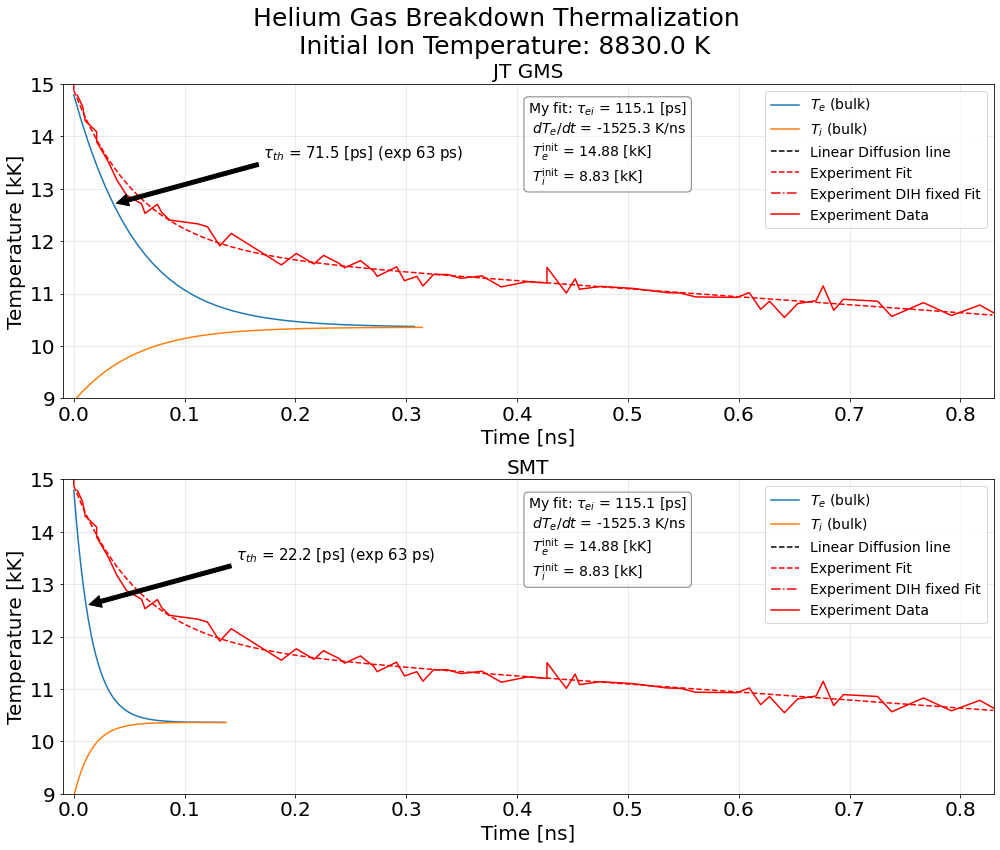

In [19]:
fig, ax = plt.subplots(2,1, figsize=(14,12),facecolor='w')
fig.suptitle('Helium Gas Breakdown Thermalization \n Initial Ion Temperature: {0:.1f} K'.format(Ti_initial),fontsize=25)
# fig.suptitle('Helium Gas Breakdown Thermalization \n MD DIH $T_i$'.format(Ti_initial),fontsize=25)

plot_bulk_temperature(ttm_jt, Helium_jt, ax = ax[0], title='JT GMS')
plot_bulk_temperature(ttm_smt, Helium_smt,  ax = ax[1], title='SMT')
fig.tight_layout()

# Adiabatic Expansion

"Collisionless expansion of a Gaussian plasma
into a vacuum" Mora


$$\frac{d \ln T_e}{dt} = 2 \frac{d \ln n_e}{dt}$$

In a cylindrical plasma with $n\propto 1/R^2$
$$\frac{d \ln T_e}{dt} = - 4 \frac{d \ln R}{dt}$$


In [23]:
dT_dt_exp = -1530 # K/ns
R0 = 25e-6 # m
Rdot =  -4*R0* dT_dt_exp/11e4
print("He expanding at {0:.3f} μm per ns".format(Rdot*1e6))

He expanding at 1.391 μm per ns
